In [1]:
from Bio import Phylo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

if False: # vscode
    style = {'axes.facecolor': '#1d1e1d',
    'axes.edgecolor': '.7',
    'axes.labelcolor': '.7',
    'figure.facecolor': '#1d1e1d',
    'grid.color': '.7',
    'text.color': '.7',
    'xtick.color': '.7',
    'ytick.color': '.7',
    'patch.edgecolor': 'w',
    }
else:
    style = {}
sns.set_style('ticks', style)

## Load trees

In [2]:
trees = Phylo.parse('/Users/kmt/Desktop/round0_1_true_trees.trees', 'nexus')
coal_intervals = list()
for tree in trees:
    depths = list(tree.depths().values())
    heights = [max(depths) - depth for depth in depths]
    coal_times = np.sort(np.unique(np.round(heights, 0))).tolist()
    intervals = list(zip(coal_times[:-1], coal_times[1:]))
    coal_intervals.append(intervals)

Number of trees and max TMRCA:

In [4]:
len(coal_intervals), max([e for tree in coal_intervals for s, e in tree])

(10000, 121211.0)

## Compute Ne

Compute mean Ne across all trees:

In [5]:
lst = list()
for intervals in coal_intervals:
    for i, (s, e) in enumerate(reversed(intervals)):
        k = i+2
        lst.append((k*(k-1)/2) * (e-s))
np.mean(lst)

10045.289696133827

Compute estimated Ne in windows, conditioning on the time of each window relative to the skyline intervals:

In [6]:
width = 1000
max_time = 150000
time_windows = list(zip(range(0, max_time, width), range(width, max_time+width, width)))

# loop over all time windows:
ml_est_data = list()
for win_start, win_end in time_windows:
    lst = list()
    
    # loop over all trees
    for tree_intervals in coal_intervals:
        ml_est = 0
        k = len(tree_intervals) + 1
        
        # loop over all coalescence intervals
        for int_start, int_end in tree_intervals:
            # test if interval overlaps window:
            if win_end > int_start and int_end > win_start:

                # compute ml Ne of overlap as mean distance to end of coalescence interval:
                
                # remaining interval at start of overlap:
                remaining_interval_at_ovl_start = int_end - max(win_start, int_start)
                # remaining interval at end of overlap:
                remaining_interval_at_ovl_end = int_end - min(win_end, int_end)
                # mean remaining interval for overlap
                mean_remaining_interval = (remaining_interval_at_ovl_start + remaining_interval_at_ovl_end) /2

                # if int_start >= win_start and int_end < win_end:
                #     mean_remaining_interval = remaining_interval_at_ovl_start

                overlap = min(win_end, int_end) - max(win_start, int_start)
                ml_est += ((k*(k-1))/2) * mean_remaining_interval * overlap / (win_end-win_start)
                
            k -= 1
        if not ml_est:
            ml_est = np.nan
        lst.append(ml_est)
    ml_est_data.append(lst)

Mean across means of skylines:

In [7]:
pd.DataFrame(np.array(ml_est_data).T, columns=time_windows).mean(axis=1).mean()

7875.968115442887

Mean across means of windows:

In [8]:
df = pd.DataFrame(np.array(ml_est_data).T, columns=time_windows)
sr = df.mean(axis=0)
sr.mean()

10871.461480447007

## Student plot

Plot kind of plot as the students made. However, they only plotted the part to the left of the pink line.

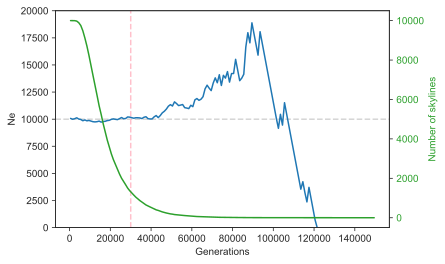

In [9]:
mid_points = [s+(e-s)/2 for s, e in time_windows]

fig, ax1 = plt.subplots()

ax1.set_xlabel('Generations')
ax1.set_ylabel('Ne')
ax1.axhline(10000, color='lightgrey', linestyle='dashed')
ax1.axvline(30000, color='pink', linestyle='dashed')
ax1.set_ylim(0, 20000)
ax1.plot(mid_points, sr.values)

nr_trees = (~df.isnull()).sum(axis=0)
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Number of skylines', color=color)
ax2.plot(mid_points, nr_trees, color=color)
ax2.tick_params(axis='y', labelcolor=color)